# Chapter 3

In [1]:
import arviz as az
import numpy as np
import pymc as pm
from matplotlib import pylab as plt
from scipy import stats

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")

In [3]:
data = np.array([1, 0, 1, 1, 1, 0, 1, 0, 1])

/Users/jingfei.yu/mambaforge/envs/rethink2_pymc4/lib/python3.9/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 ch

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


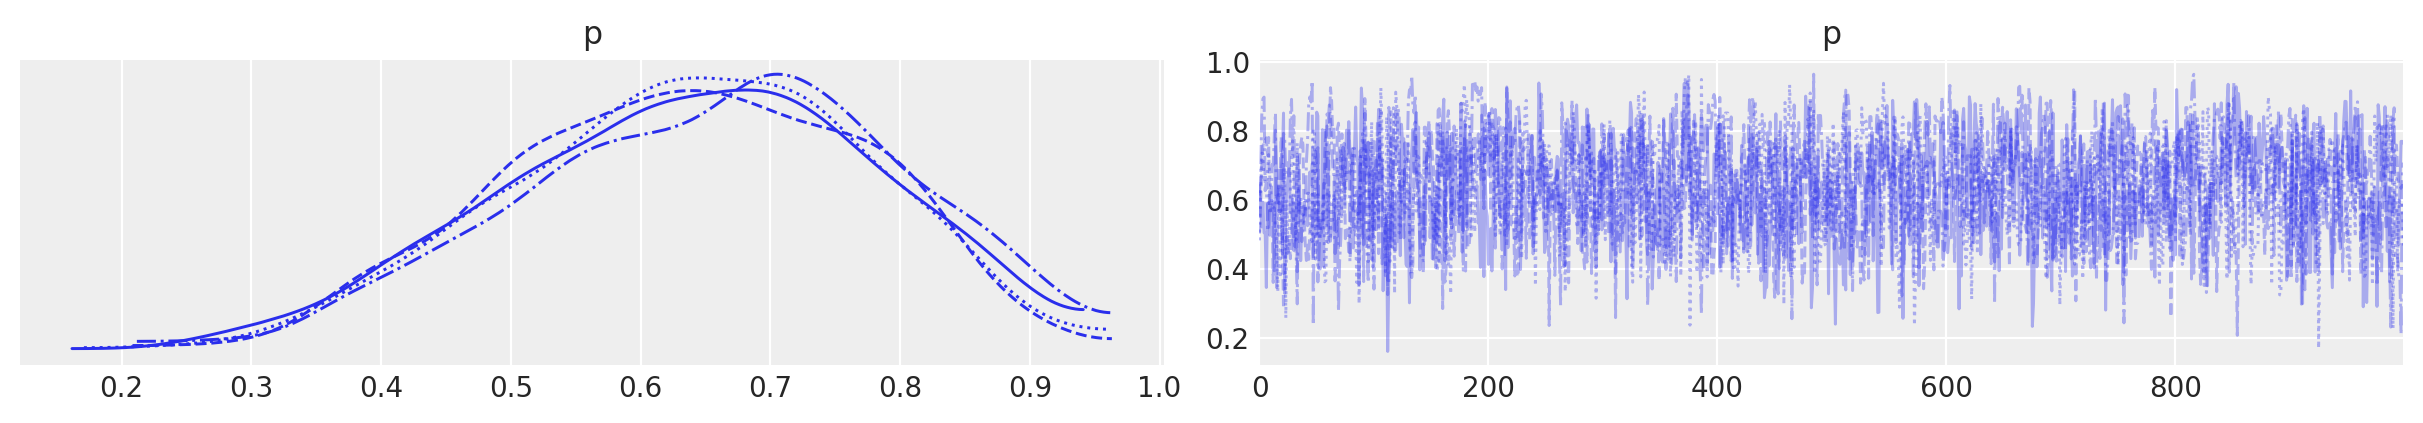

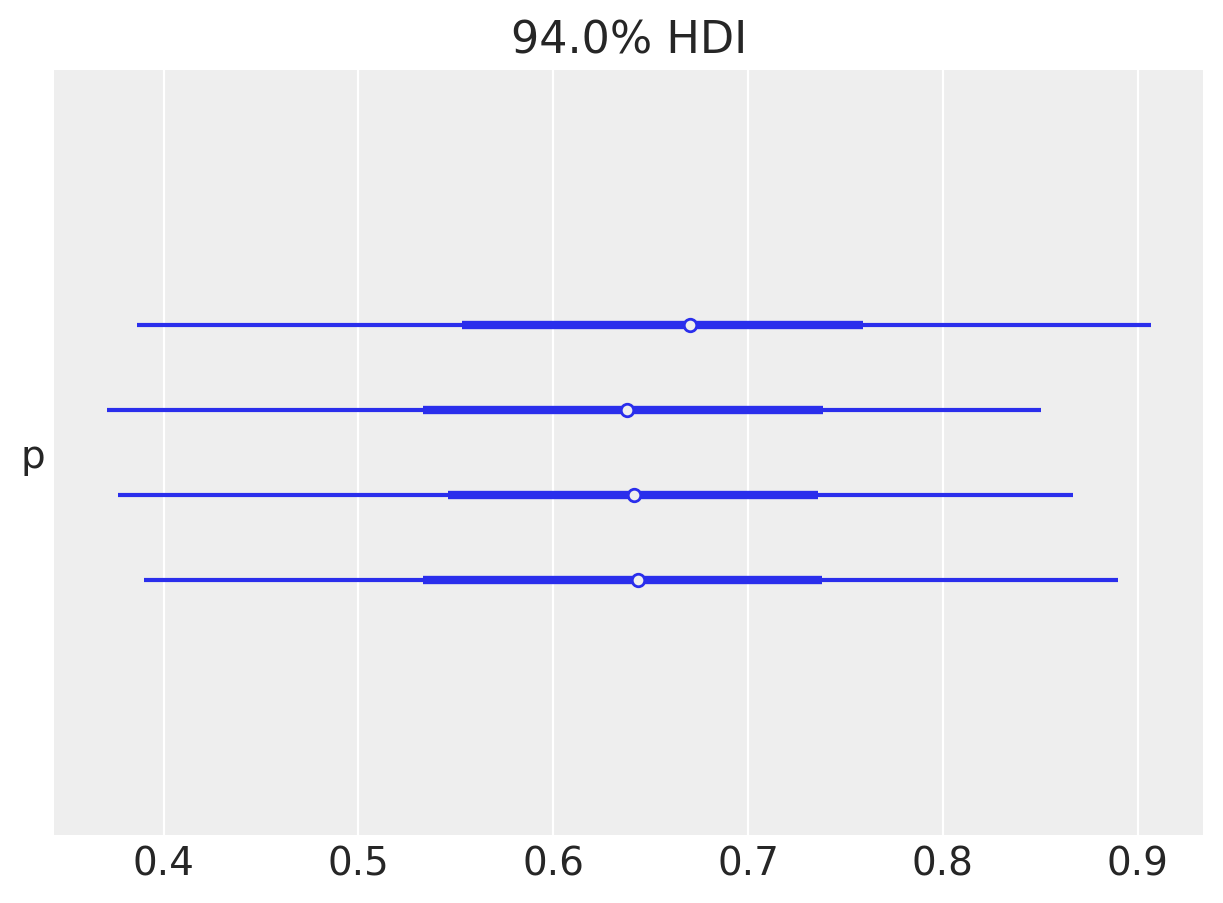

In [4]:
with pm.Model() as model:
    p = pm.Uniform("p")  # set the prior
    y = pm.Bernoulli("y", p=p, observed=data)  # posterior
    trace = pm.sample(1000, chains=4)  # get 1000 random samples
    az.plot_trace(trace)
    az.plot_forest(trace, var_names=["p"])

In [5]:
samples = az.extract(trace.posterior)["p"].values

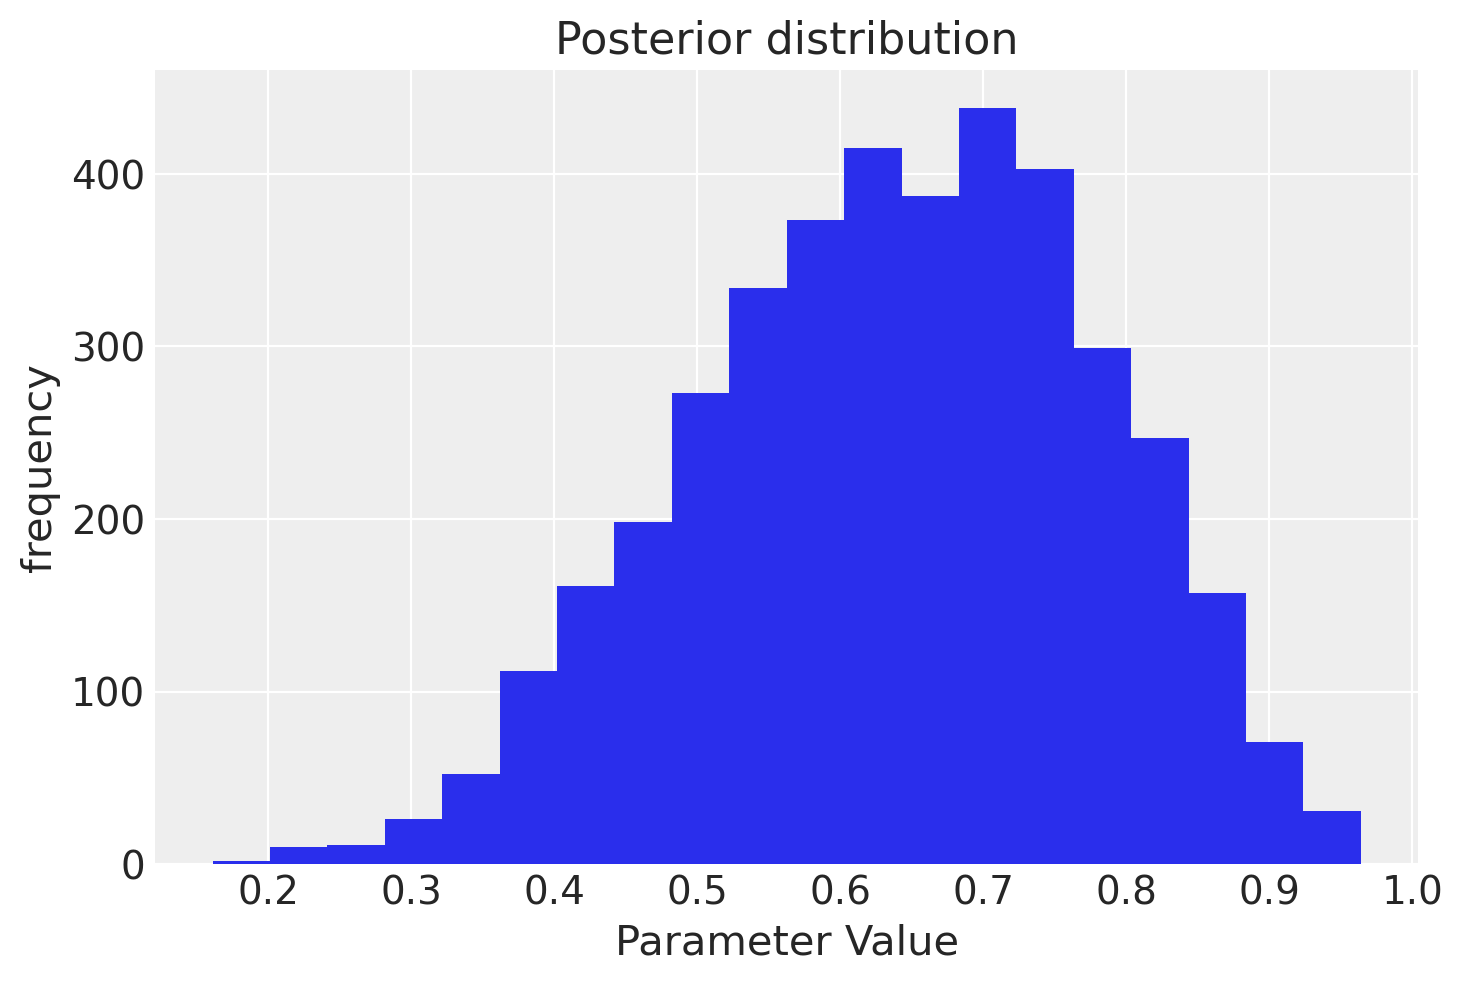

In [6]:
# plot the posterior
plt.hist(samples, bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

### 3E1.
How much posterior probability lies below p = 0.2?

In [7]:
np.sum(samples < 0.2) / samples.size

0.0005

### 3E2.
How much posterior probability lies above p = 0.8?

In [8]:
np.sum(samples > 0.8) / samples.size

0.134

### 3E3.
How much posterior probability lies between p = 0.2 and p = 0.8?

In [9]:
np.sum(np.where(samples < 0.2, 0, np.where(samples <= 0.8, 1, 0))) / samples.size

0.8655

In [10]:
# or subtract
1 - np.sum(samples < 0.2) / samples.size - np.sum(samples > 0.8) / samples.size

0.8655

### 3E4.
20% of the posterior probability lies below which value of p?

In [11]:
np.quantile(samples, 0.2)

0.5150609109145893

### 3E5.
20% of the posterior probability lies above which value of p?

This is just the 80% quantile

In [12]:
np.quantile(samples, 0.8)

0.7638560358634765

### 3E6.
Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [13]:
hpd_interval = az.hdi(samples, hdi_prob=0.66)

In [14]:
hpd_interval

array([0.50559428, 0.78441898])

### 3E7.
Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [15]:
# no actual function that does this, but we can find the lower and upper 1/6 quantiles, which gets you the central 66% quantile

np.quantile(samples, (1 / 6, 5 / 6))

array([0.4965576, 0.7810424])

### 3M1.
Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before

In [16]:
def posterior_calc(w, n, prior, p_grid_value):
    # P(p|data) = P(data|p)P(p)/p(data)
    likelihood = stats.binom.pmf(k=w, n=n, p=p_grid_value)
    posterior = likelihood * prior
    # normalize
    posterior = posterior / np.sum(posterior)
    return posterior

Text(0, 0.5, 'posterior probability')

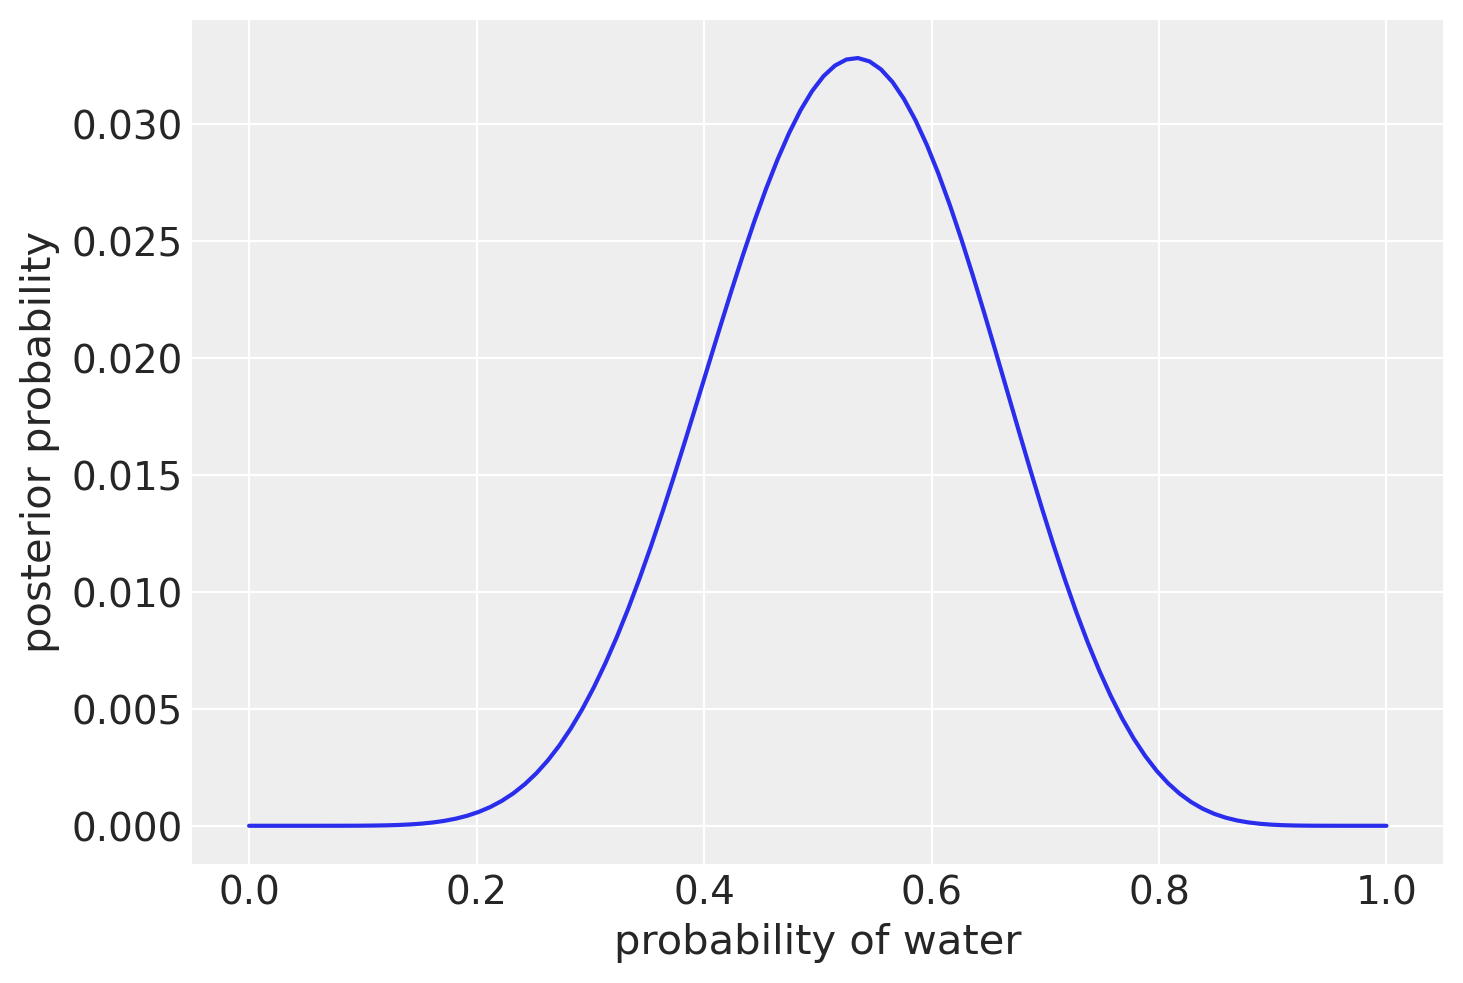

In [17]:
p_grid = np.linspace(0, 1, 100)
post = posterior_calc(w=8, n=15, prior=1, p_grid_value=p_grid)

plt.plot(p_grid, post)
plt.xlabel("probability of water")
plt.ylabel("posterior probability")

### 3M2.
Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p

In [19]:
# so we will be drawing p from the p_grid 10000 times, replace the choices every time, and each values from p_grid is weighted by its posterior probability
samples = np.random.choice(p_grid, size = 10000, replace = True, p=post)

In [20]:
az.hdi(samples)

array([0.31313131, 0.74747475])

### 3M3.
Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?

In [21]:
ppd = np.random.binomial(n=15, p=samples)

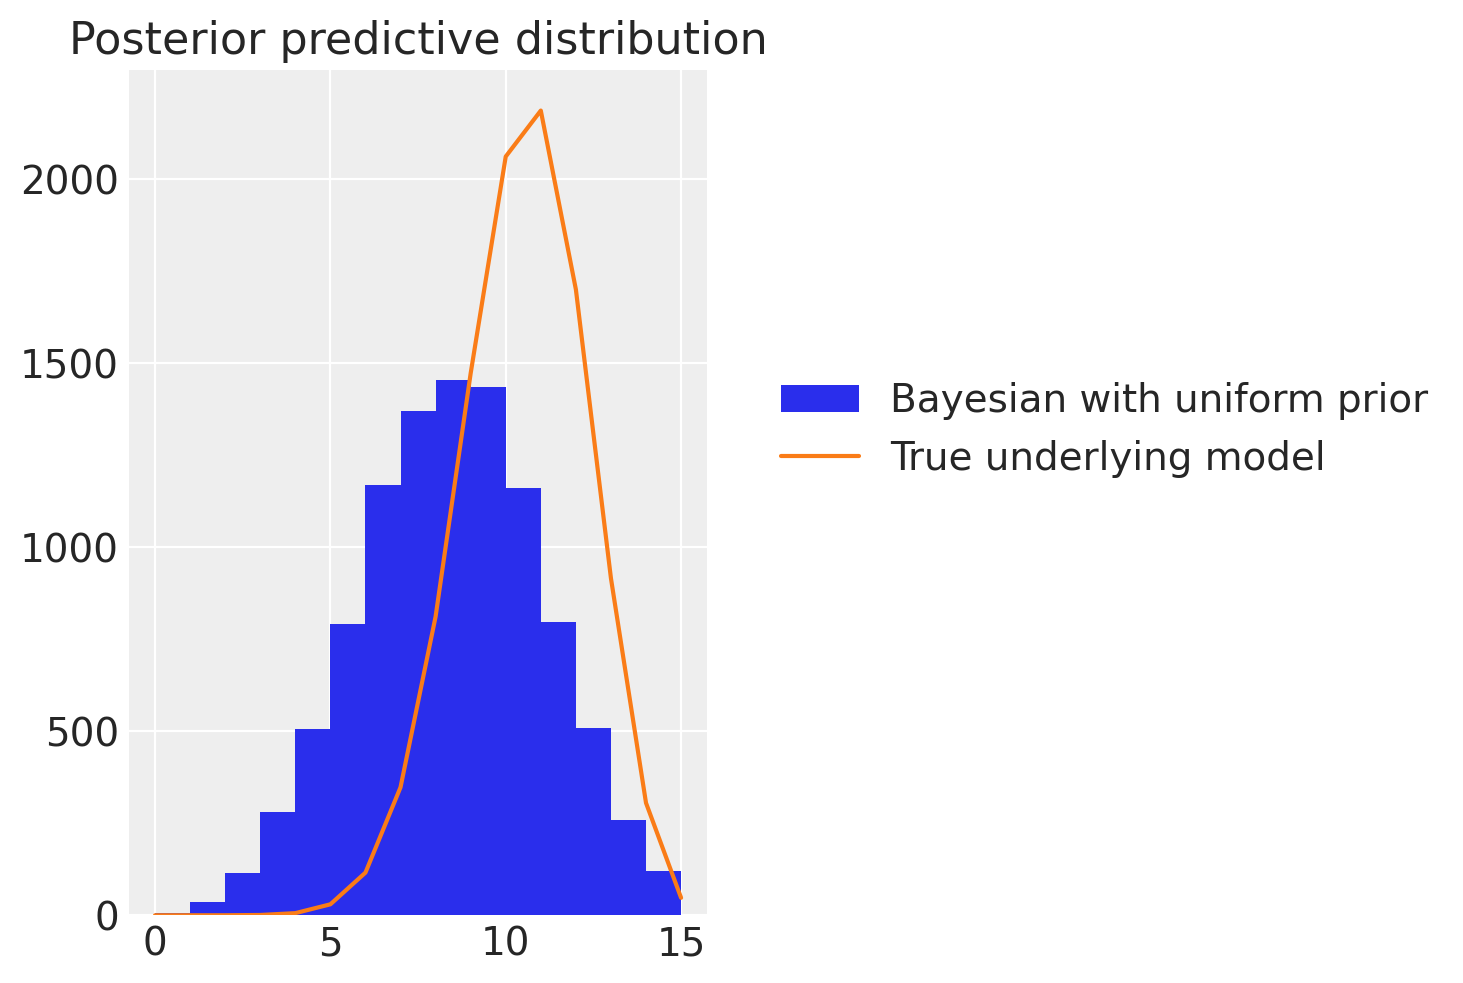

In [22]:
plt.hist(ppd, bins = 15, label = 'Bayesian with uniform prior')
plt.plot(
    np.linspace(0, 15, 16),
    10000*stats.binom.pmf(np.linspace(0,15,16), n=15, p= 0.7),
    label = "True underlying model", # we knew this from 3M5
)
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1, 0.5));

The PPD looks close to the data (i.e. we are seeing 8 W out of 15 tosses). there are some spreads

In [23]:
np.sum(ppd==8)/ppd.shape

array([0.1453])

### 3M4.
Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [24]:
np.sum(ppd==6)/ppd.size

0.1168

### 3M5.
Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5.
This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each
problem above and compare the inferences. What difference does the better prior make? If it helps,
compare inferences (using both priors) to the true value p = 0.7

In [25]:
step_prior = np.heaviside(p_grid - 0.5, 0.5) * 2

In [26]:
post = posterior_calc(w=8, n=15, prior=step_prior, p_grid_value=p_grid)

Text(0, 0.5, 'posterior probability')

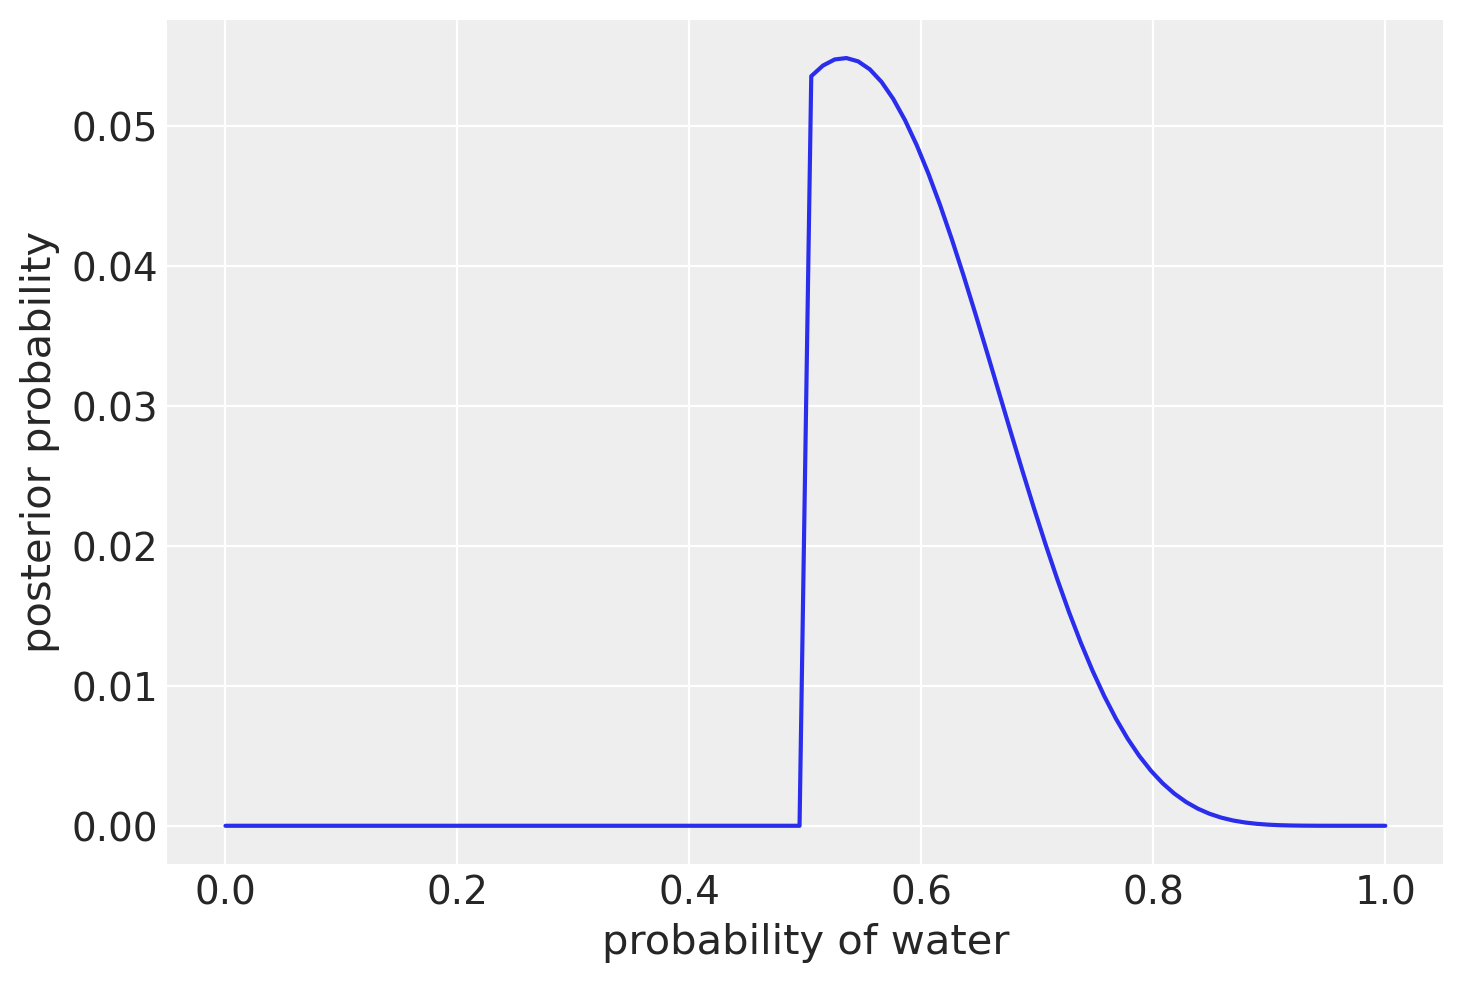

In [27]:
plt.plot(p_grid, post)
plt.xlabel("probability of water")
plt.ylabel("posterior probability")

In [28]:
samples = np.random.choice(p_grid, size = 10000, replace = True, p=post)

In [29]:
ppd_step = np.random.binomial(n=15, p=samples)

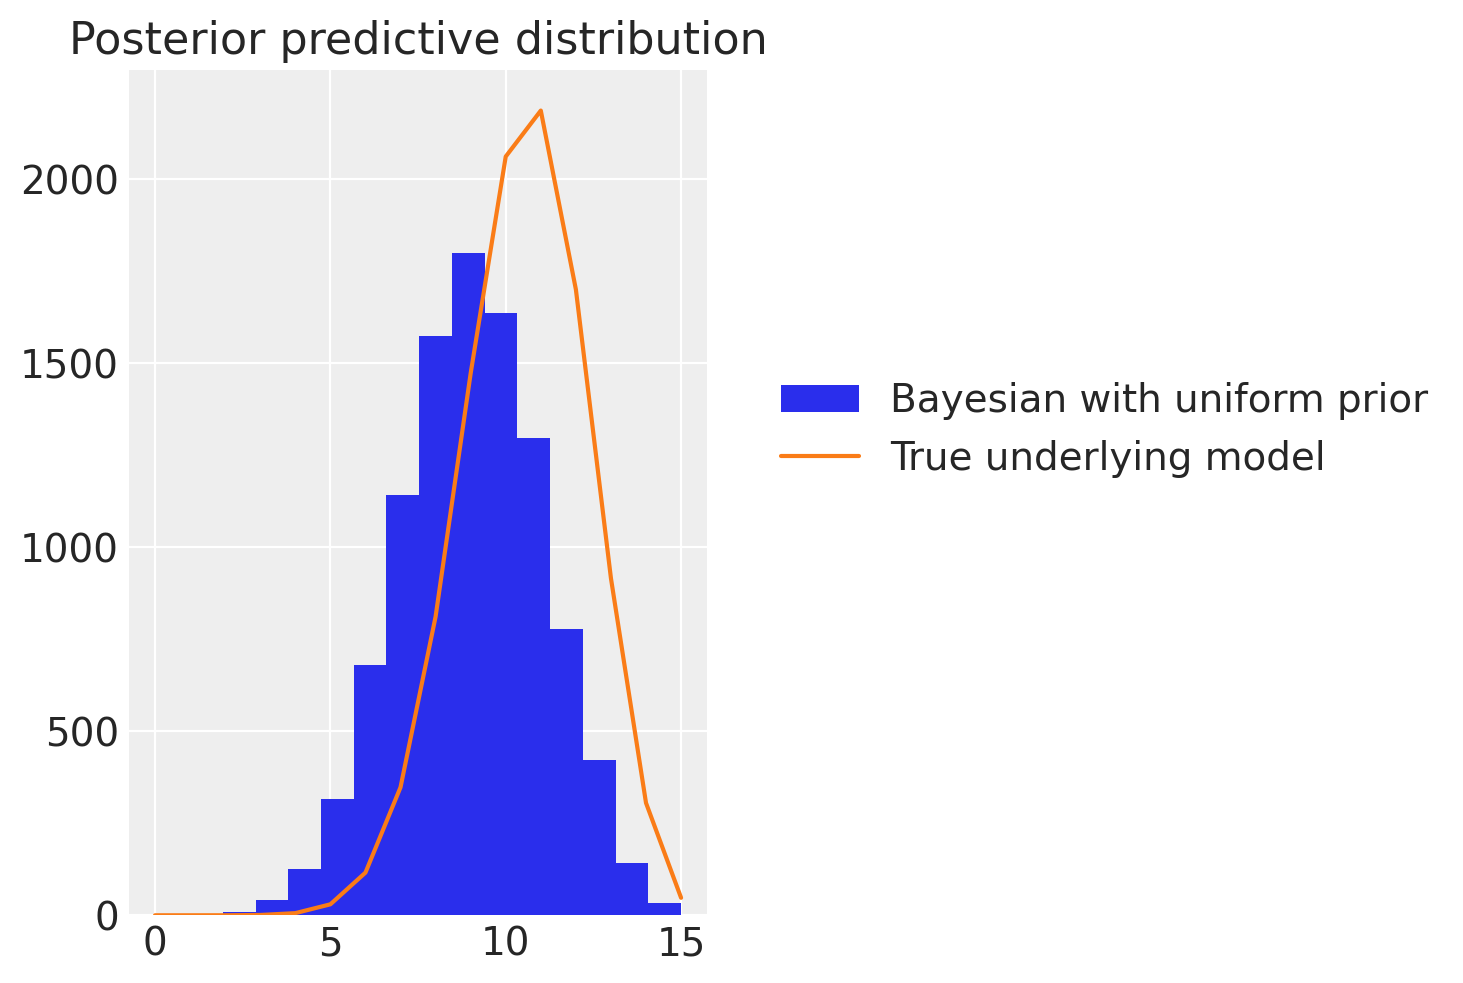

In [30]:
plt.hist(ppd_step, bins = 15, label = 'Bayesian with uniform prior')
plt.plot(
    np.linspace(0, 15, 16),
    10000*stats.binom.pmf(np.linspace(0,15,16), n=15, p= 0.7),
    label = "True underlying model", # we knew this from 3M5
)
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1, 0.5));

narrower, and closer to the true distribution than the uninformed prior

In [31]:
az.hdi(samples, hdi_prob=0.9)

array([0.50505051, 0.70707071])

This is now a much narrower range than the previous one ([0.31313131, 0.74747475])

So this more informed prior increases the predicative power. I don't think this case is particularly convincing, but the numbers do tend to that direction


### 3M6.

Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you
want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means
the distance between the upper and lower bound of the interval should be 0.05. How many times will
you have to toss the globe to do this?

**Answer**

we simulate the situation with different numbers of trials and try to see what's the correlation between the # of trials and the width of the interval

We know that the posterior is a beta function, so we will just use that to calculate the 99th percentile

In [38]:
p = 0.7
num_trials = []
for i in range(100):
    n = 0
    w = 0
    interval = (0.005, 0.995)
    while interval[1] - interval[0] > 0.05:
        w += np.random.binomial(1, p) #add a flip
        n += 1
        interval = stats.beta.interval(0.99, w+1, n-w+1)
    num_trials.append(n)
mean = np.array(num_trials).mean()

In [34]:
mean

2221.35

we can then do this for multiple values of p

In [35]:
p_grid = np.linspace(0, 1, 10)

trials_p = []
for p in p_grid:
    num_trials = []
    for i in range(100):
        n = 0
        w = 0
        interval = (0.005, 0.995)
        while interval[1] - interval[0] > 0.05:
            w += np.random.binomial(1, p) #add a flip
            n += 1
            interval = stats.beta.interval(0.99, w+1, n-w+1)
        num_trials.append(n)
    mean = np.array(num_trials).mean()
    trials_p.append(mean)

Text(0, 0.5, 'num of trials needed')

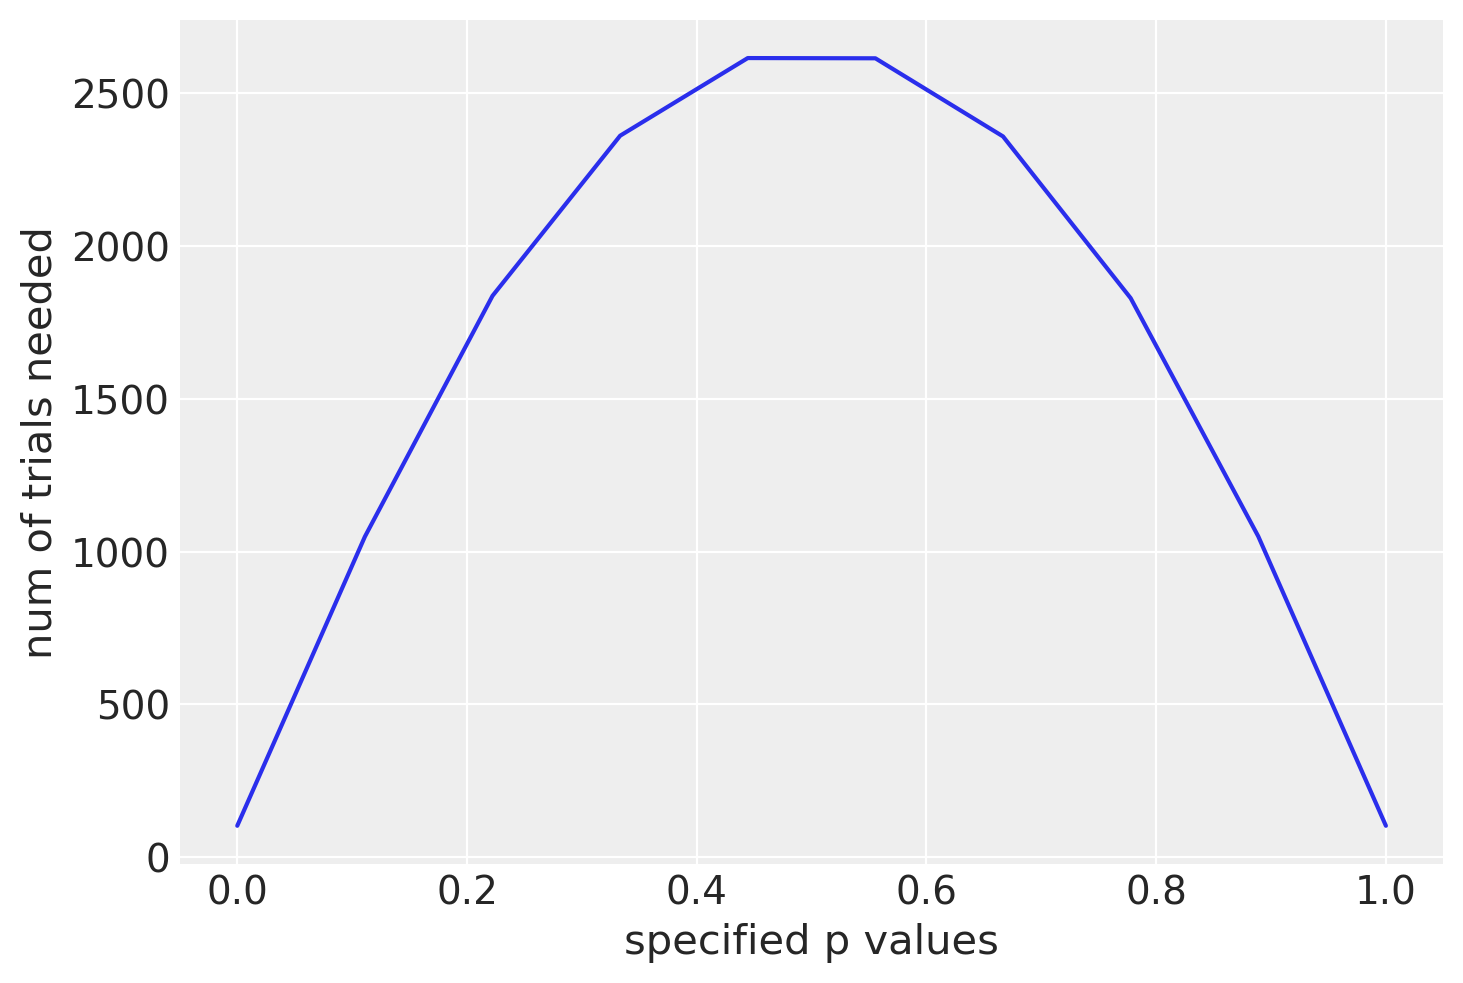

In [44]:
plt.plot(p_grid, trials_p)
plt.xlabel('specified p values')
plt.ylabel('num of trials needed')

### Hard.
The Hard problems here all use the data below. These data indicate the gender (male=1, female=0) of officially reported first and second born children in 100 two-child families.


In [45]:
# fmt: off
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,
1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,
1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])
# fmt: on

### 3H1.
Using grid approximation, compute the posterior distribution for the probability of a birth
being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior
probability?

**Answer**

so we don't care about whether the birth is first or second, we treat the data as a whole

In [54]:
birth = np.concatenate((birth1, birth2))

In [55]:
prior = 1

In [56]:
sum(birth)

111

In [58]:
len(birth)

200

In [59]:
p_grid = np.linspace(0, 1, 100)

In [61]:
post = posterior_calc(sum(birth), len(birth), prior, p_grid)

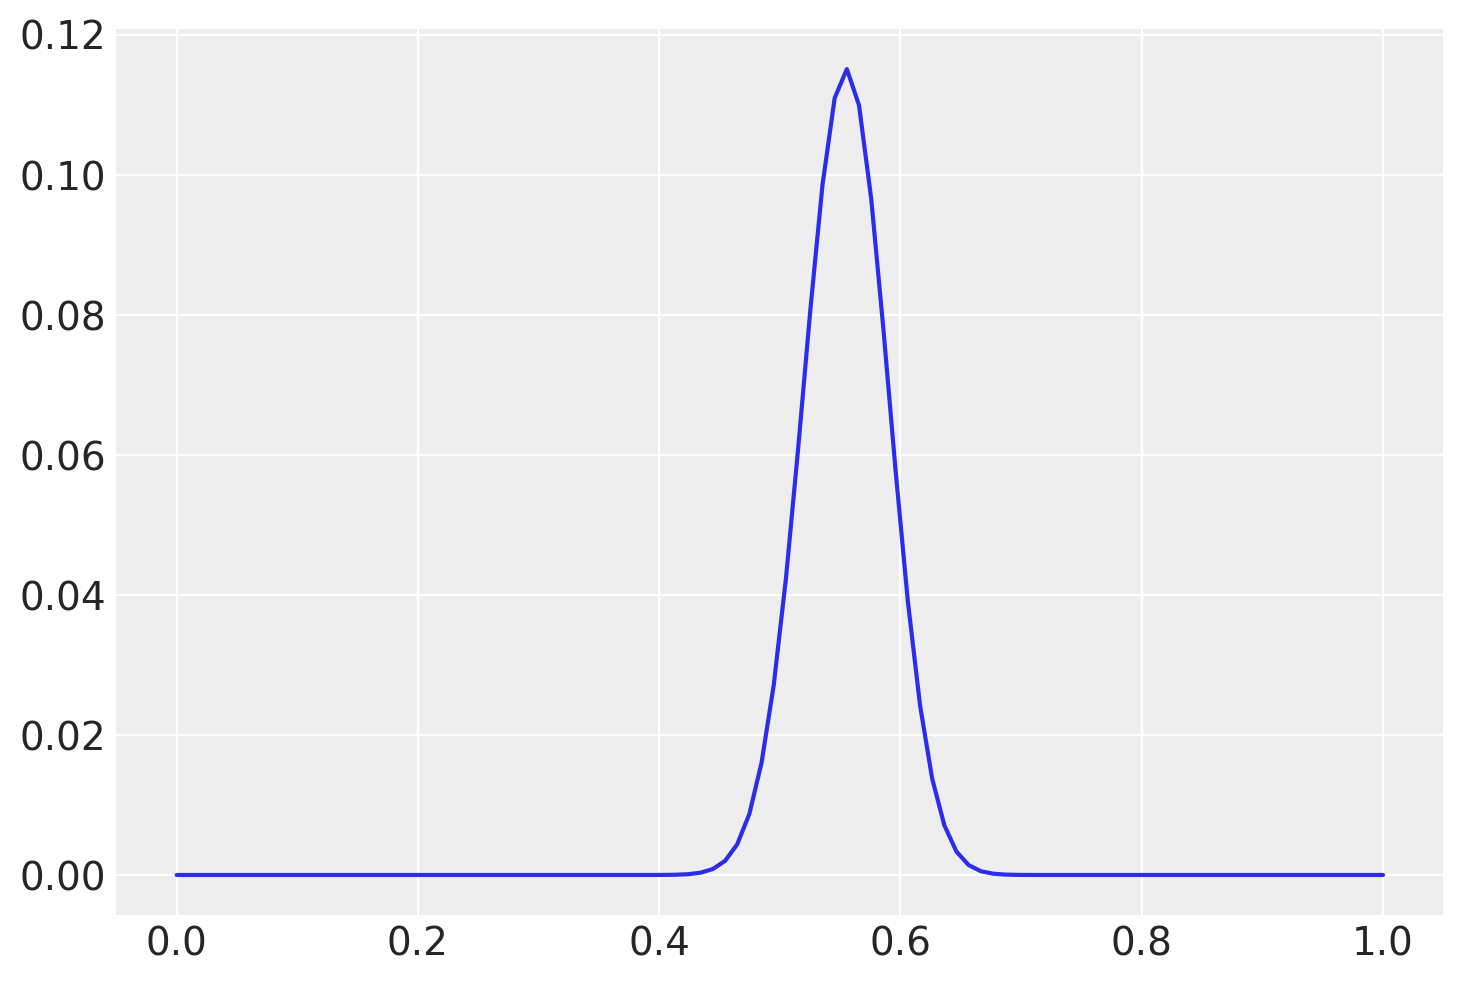

In [63]:
plt.plot(p_grid, post)

looks like the MAP is somewhere like 0.5

In [67]:
p_grid[np.argmax(post)]

0.5555555555555556

it's 0.555

### 3H2.
Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior
density intervals.

In [69]:
samples_3h2 = np.random.choice(p_grid, size = 10000, replace = True, p=post)

In [71]:
az.hdi(samples_3h2, 0.5)

array([0.54545455, 0.58585859])

In [72]:
az.hdi(samples_3h2, 0.89)

array([0.49494949, 0.60606061])

In [73]:
az.hdi(samples_3h2, 0.97)

array([0.48484848, 0.62626263])

It appears that 0.5 is within all the HPDI reported, so it's fairly close to what we'd expect

### 3H3.
Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers
of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to
visualize the simulations, but the dens command (part of the rethinking package) is probably the
easiest way in this case. Does it look like the model fits the data well? That is, does the distribution
of predictions include the actual observation as a central, likely outcome?

In [74]:
ppd_3h2 = np.random.binomial(n=200, p=samples_3h2)

In [111]:
len(ppd_3h2)

10000

(array([   2.,   21.,  108.,  278.,  670., 1175., 1765., 1638., 1849.,
        1347.,  748.,  287.,   87.,   21.,    4.]),
 array([ 74.        ,  78.86666667,  83.73333333,  88.6       ,
         93.46666667,  98.33333333, 103.2       , 108.06666667,
        112.93333333, 117.8       , 122.66666667, 127.53333333,
        132.4       , 137.26666667, 142.13333333, 147.        ]),
 <BarContainer object of 15 artists>)

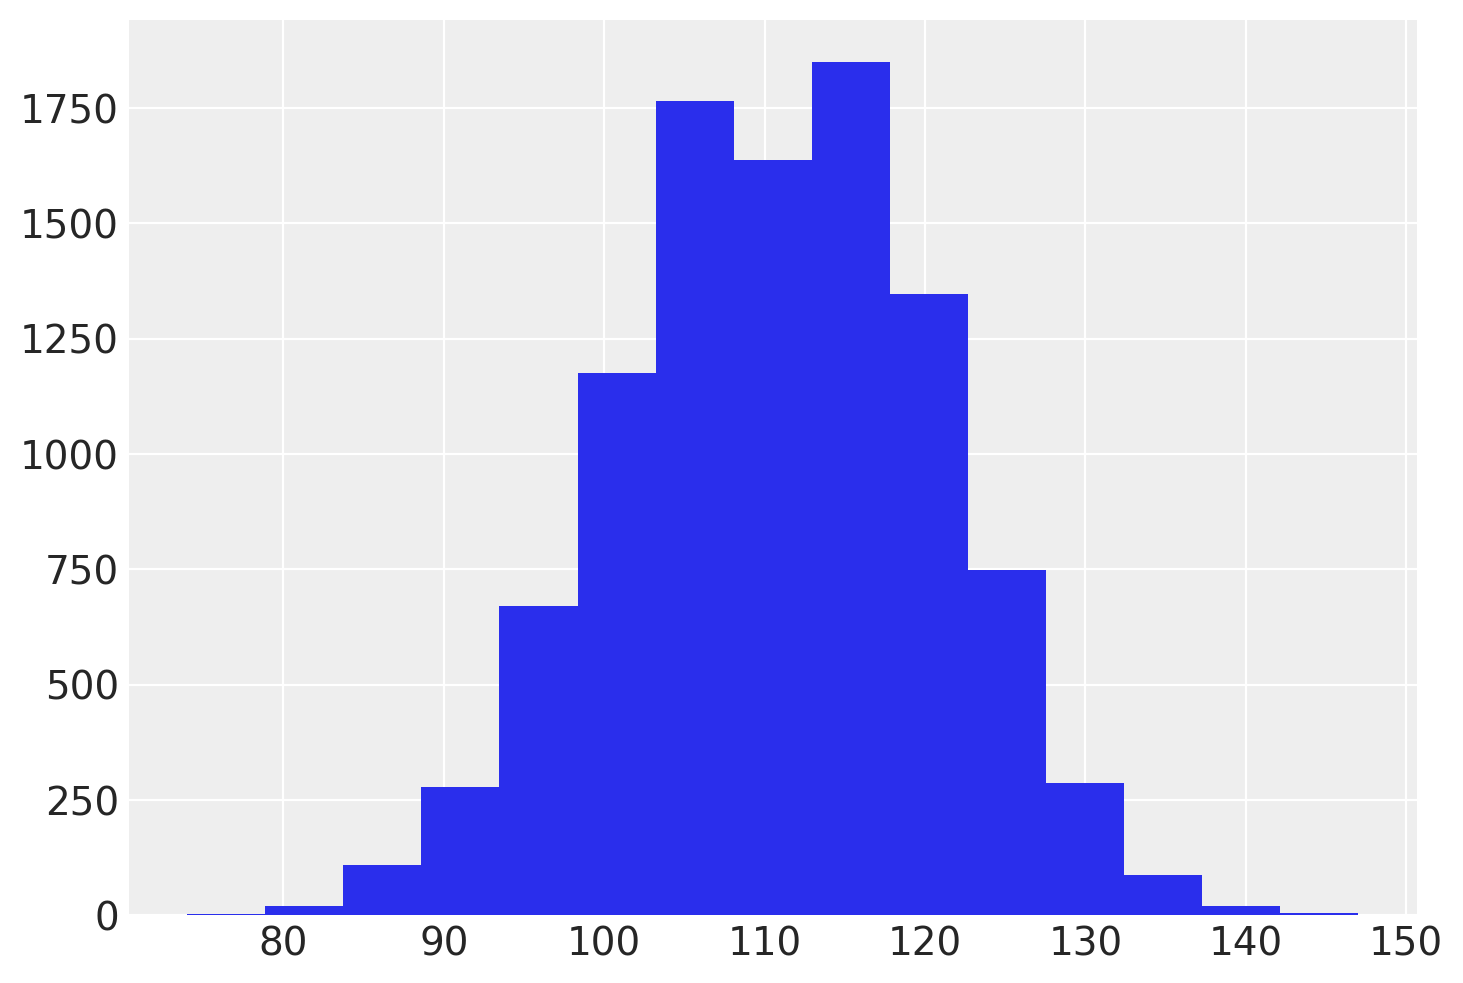

In [112]:
plt.hist(ppd_3h2, bins = 15, label = 'simulated ppd')


seeing this is close to 111 boys

### 3H4.
Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys
in the first births, birth1. How does the model look in this light?

**Answer**

Okay, I am assuming this means that we will to re-run the simulation based only on the first born?

In [115]:
prior = 1

In [116]:
p_grid = np.linspace(0, 1, 100)

In [117]:
post = posterior_calc(sum(birth1), len(birth1), prior, p_grid)

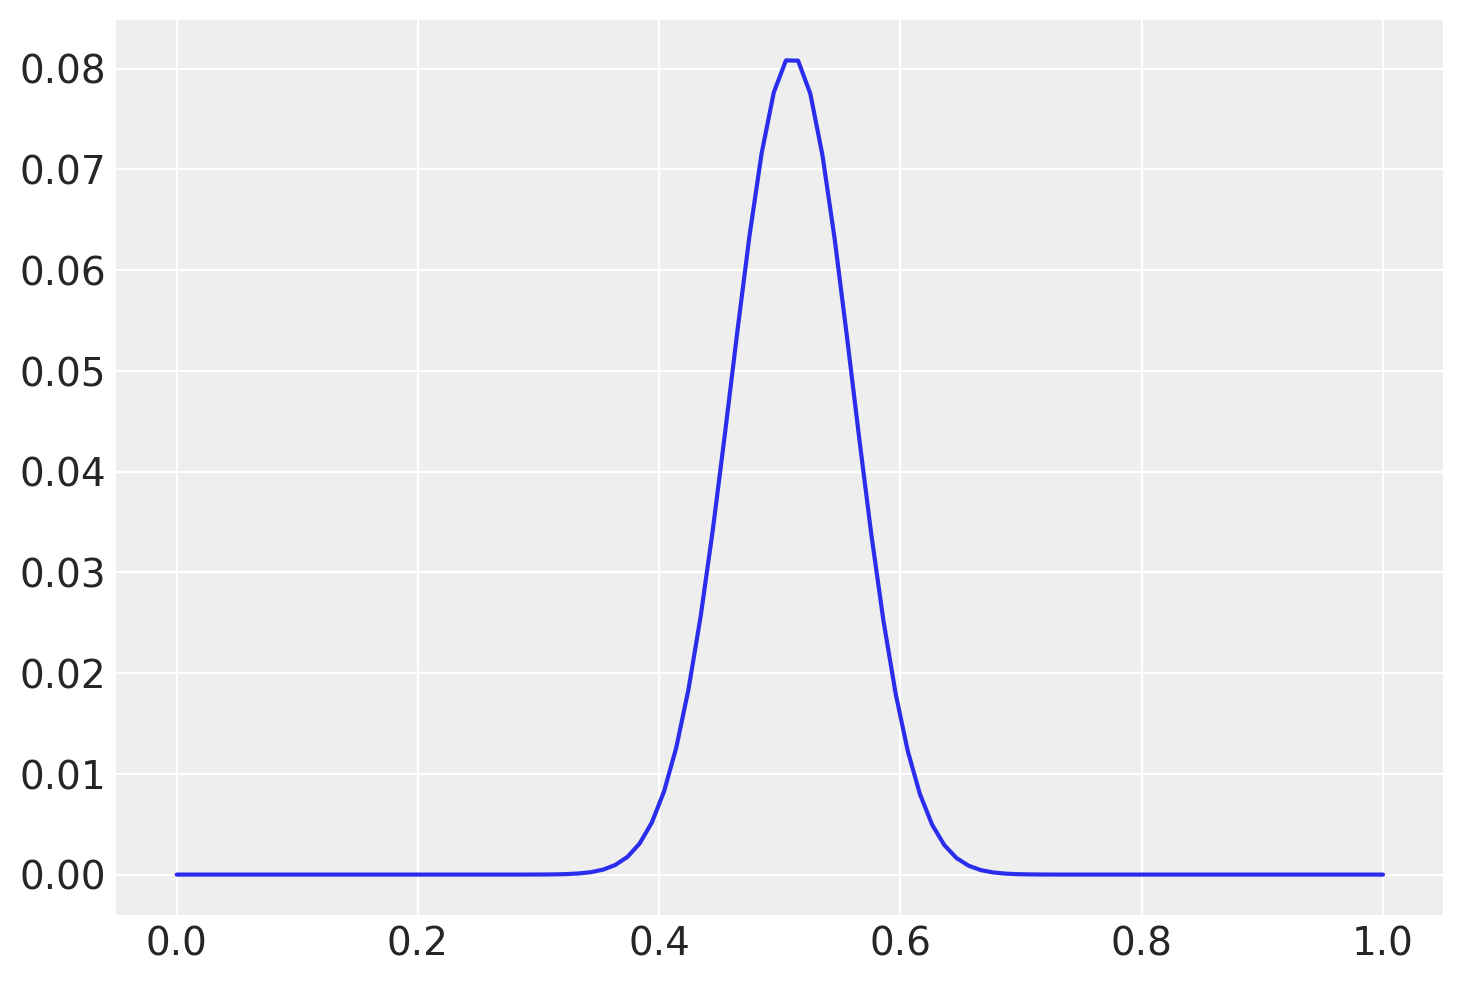

In [118]:
plt.plot(p_grid, post)

In [119]:
p_grid[np.argmax(post)]

0.5050505050505051

Now the MAP is a bit less than the one with all the births. This might just because of the lack of data

In [120]:
samples_3h4 = np.random.choice(p_grid, size = 10000, replace = True, p=post)

In [121]:
az.hdi(samples_3h4, 0.5)

array([0.47474747, 0.53535354])

In [122]:
az.hdi(samples_3h4, 0.89)

array([0.43434343, 0.58585859])

In [123]:
az.hdi(samples_3h4, 0.97)

array([0.4040404 , 0.60606061])

Still, 0.5 is within all the HPDI

In [129]:
ppd_3h4 = np.random.binomial(n=100, p=samples_3h4)

(array([   6.,   31.,   98.,  384.,  619., 1076., 1963., 1709., 1486.,
        1482.,  642.,  327.,  147.,   24.,    6.]),
 array([26.        , 29.33333333, 32.66666667, 36.        , 39.33333333,
        42.66666667, 46.        , 49.33333333, 52.66666667, 56.        ,
        59.33333333, 62.66666667, 66.        , 69.33333333, 72.66666667,
        76.        ]),
 <BarContainer object of 15 artists>)

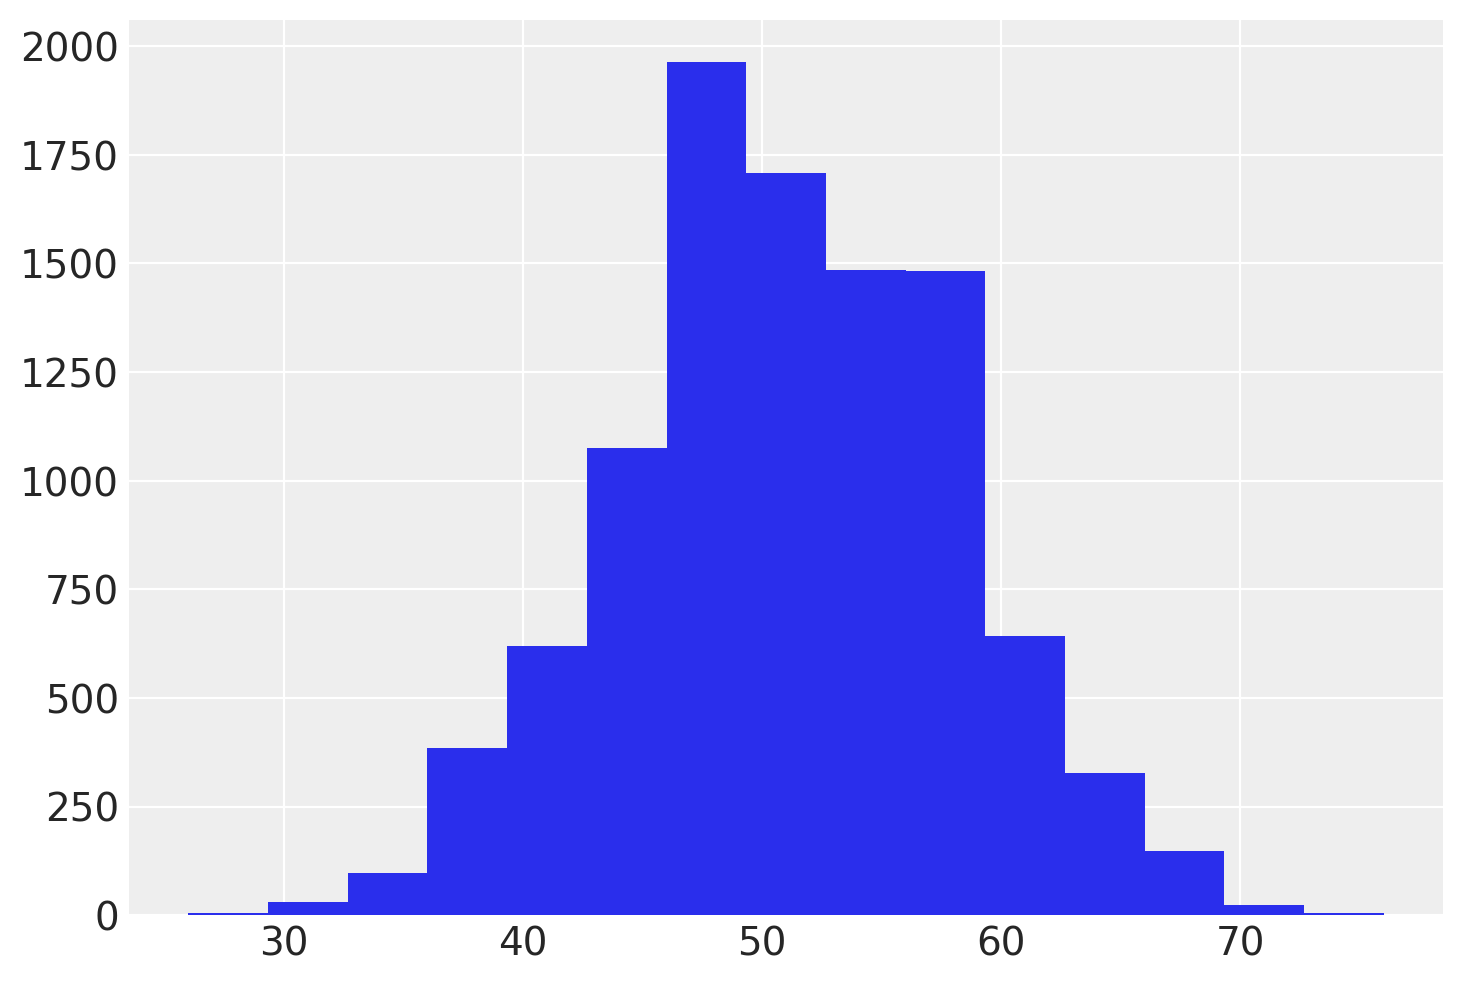

In [130]:
plt.hist(ppd_3h4, bins = 15, label = 'simulated ppd')

In [131]:
np.mean(ppd_3h4)

50.9611

In [128]:
sum(birth1)

51

The model still looks correct

### 3H5.
The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts
of boys to only those second births that followed girls. To do this correctly, you need to count the
number of first borns who were girls and simulate that many births, 10,000 times. Compare the
counts of boys in your simulations to the actual observed count of boys following girls. How does the
model look in this light? Any guesses what is going on in these data?

In [133]:
# I need to get the male births that followed female first borns
birth3 = birth2[birth1==0]

In [134]:
sum(birth3)

39

In [135]:
len(birth3)

49

In [147]:
ppd_3h5 = np.random.binomial(n=len(birth3), p=samples_3h4)

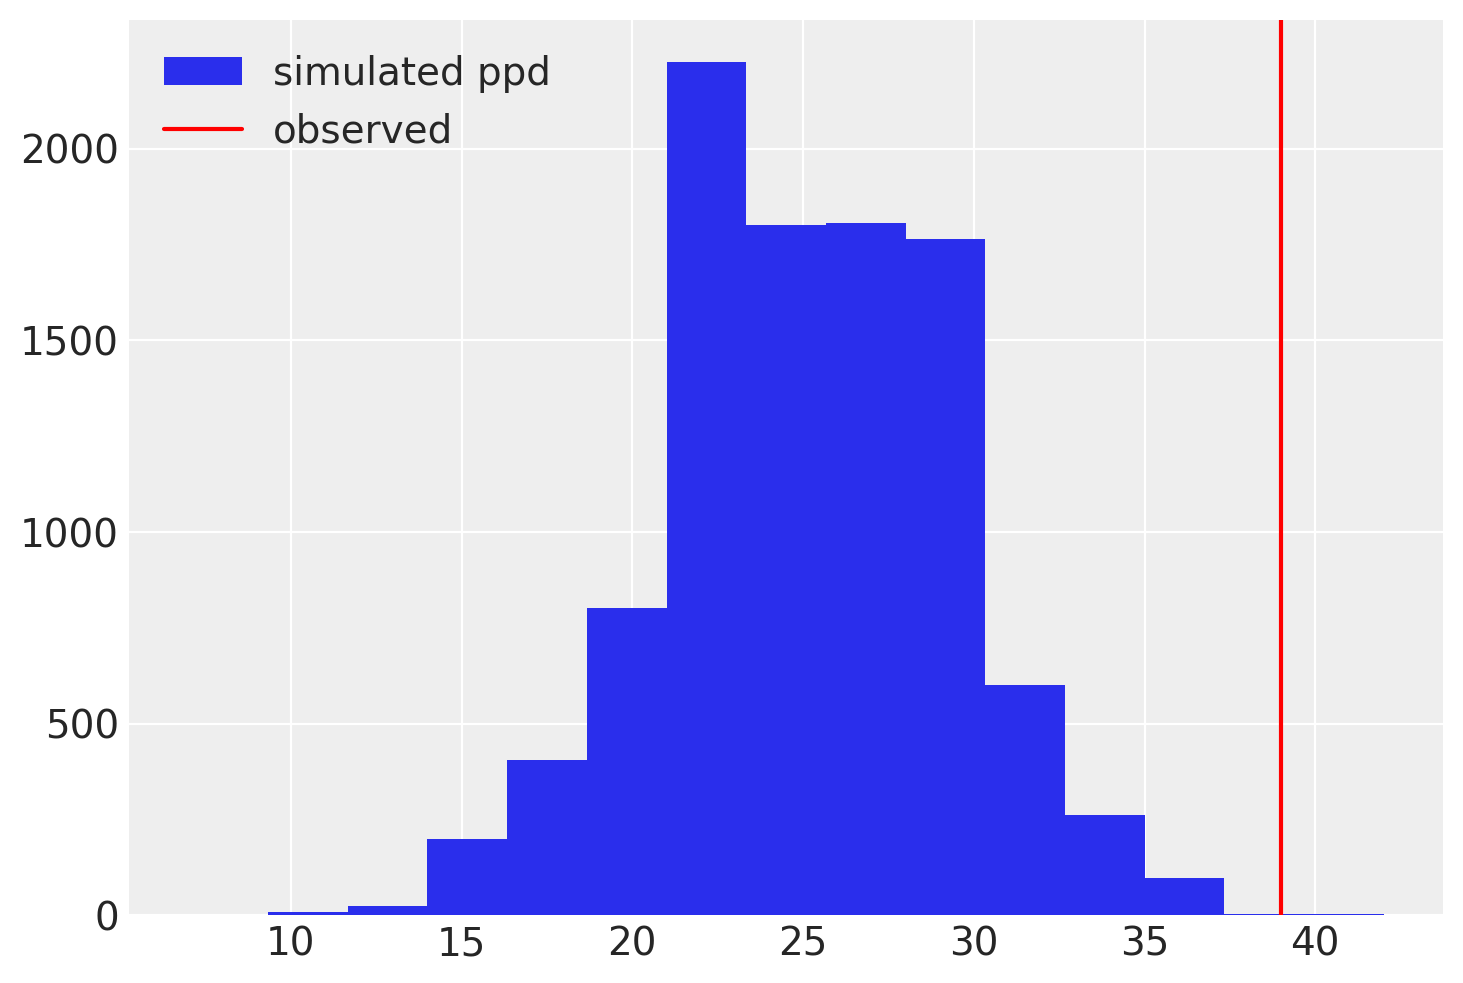

In [148]:
plt.hist(ppd_3h5, bins = 15, label = 'simulated ppd')
plt.axvline(np.sum(birth3), c = 'r', label = 'observed')
plt.legend()

This does not line up with the model! it seem that there is some correlation between the genders of the first and second child

In [149]:
%watermark -n -u -v -iv -w

Last updated: Mon Jan 02 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.7.0

matplotlib: 3.6.2
pymc      : 5.0.1
scipy     : 1.9.3
arviz     : 0.14.0
numpy     : 1.24.1

Watermark: 2.3.1

